Bu yazımızda Microsot tarafından hazırlanan ve Kaggle gibi platformlarda oldukça popülerleşen [LightGBM](https://github.com/Microsoft/LightGBM) kütüphanesini tanıtacağız. `LightGBM` kullanımı artan gradient boosting yöntemini kullanan bir kütüphane. Gradient Boosting yöntemini kullanan başka kütüphane ve modüller de mevcut. Örneğin [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) üzerinden kullanabileceğiniz bir modül var. R kullanmayı tercih edenler için [gbm](https://cran.r-project.org/package=gbm) kütüphanesi bir diğer alternatif. Ayrıca R ve Python üzerinde çalışabilen ve yine oldukça popüler bir kütüphane olan [xgboost](https://github.com/dmlc/xgboost) da gradient boosting yöntemini kullanan paketlere örnek olarak verilebilir. `xgboost` ve `gbm` paketlerini kullanmadığımı söylemem lazım. `xgboost` paketini Python üzerinden kullanmak çok kolay değil; ancak R üzerinden yüklemek Python'a göre daha kolay. `scikit-learn` paketine kıyasla `LightGBM`in avantajı ise oldukça hızlı olması. Hız farkı GPU kullanmadığınızda bile rahatlıkla görebileceğiniz düzeyde. `LightGBM` aynı zamanda `scikit-learn` komutlarını kullanmanıza imkan tanıyan bir katman (wrapper) ile geliyor.

# Boosting

Boosting, kullanımı her geçen gün artan topluluk öğrenme (ensemble learning) yöntemlerinden biri. Boosting yöntemlerinin temeli, tahminleri rassal tahminden biraz daha başarılı zayıf öğrenen modellerin (weak learner) topluluk olarak tahmin yapması esasına dayanıyor. Örnek olarak bir ikili sınıflandırma problemi için zayıf öğrenen model, 0.5 olasılıktan biraz daha yüksek başarıyla tahmin yapan bir model olabilir. Boosting yöntemlerinde bu modeller sıralı olarak ve belirli ağırlıklar verilerek oluşturulur. AdaBoost yöntemi hatalı tahminlerin ağırlıklarını arttırarak sıradaki modeli oluşturarak hatayı azaltmaya çalışır. Gradient Boosting ise o iterasyonda yapılan hataları bir sonraki modelde öğrenmeye çalışarak tahmin yapar. Bu sayede ilk modellerde verideki örüntüler kabaca öğrenilir ve ileriki iterasyonlarda da yapılan hatalar düzeltilmeye çalışılır. Hatayı öğrenmek aynı zamanda modelin daha karmaşık yapıları öğrenebilmesini de sağlar. Gradient boosting ismi, tahmin etmeye çalıştığımız hatanın, fonksiyonunun gradyanının negatifine denk gelmesinden gelmektedir. 

# LightGBM
`LightGBM` paketinin [dokümantasyonu](https://lightgbm.readthedocs.io/en/latest/) parametreleri açıklama ve API'ı tanıtma konusunda başarılı. Aynı zamanda çeşitli uygulama örnekleri de mevcut. Paketi yüklemek için `VC runtime` uygulamasını yüklemiş olmanız şart. Uygulama Visual C++ yüklü olmayan bilgisayarlarda da `LightGBM`'in çalışmasını sağlayacak kütüphaneleri içeriyor. Bunu yükledikten sonra `pip` ya da `conda` ile yükleme yapabilirsiniz. Yükleme hakkında detaylı bilgi almak için [paketin dokümanlarına](https://github.com/Microsoft/LightGBM/tree/master/python-package) bakabilirsiniz.

Bu paket benim dikkatimi Kaggle üzerindeki [Instacart](https://www.kaggle.com/c/instacart-market-basket-analysis) yarışmasıyla çekmişti. Bu yarışmanın forumlarındaki örneklere bakmanızı da tavsiye ederim. Hem verinin hazırlanması, hem de `LightGBM`in kullanımı konusunda iyi uygulamalara rastlayabilirsiniz.

Şimdi `LightGBM` paketinin kullanımını UCI dizinindeki [banka pazarlama veri kümesi](https://archive.ics.uci.edu/ml/datasets/bank+marketing) üzerinden inceleyelim. Amaç müşterilerin özelliklerine ve ekonomik göstergelere bakarak müşterilerin kampanya tekliflerine dönüş yapıp yapmayacağını tahmin etmek. Elimizdeki problem iki sınıftan oluşan bir sınıflandırma problemi, ancak `LightGBM` farklı problem sınıfları için de kullanılabiliyor.

Paketleri yükleyerek ve veri kümesini okuyarak başlayalım.

In [1]:
# Veri çerçevesi oluşturmak için Pandas paketini kullanıyoruz.
import pandas as pd
# Veri kümesini ikiye bölmek ve performans ölçütlerinin hesaplanması için gerekli modüller.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
# Grafik çizdirmek için gerekli paket.
import matplotlib.pyplot as plt
# LightGBM paketi.
import lightgbm as lgb
import numpy as np
#Uyarı mesajlarını kapatmak için
import warnings
warnings.filterwarnings("ignore")
# Veri çerçevelerini daha güzel görselleştirmek için
from IPython.display import display, HTML
# Veri kümesini okuyalım ve etiketleri ayıralım. Veri çerçevesindeki sütun isimlerini de değiştiriyoruz.
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
y= (df['y'] == 'yes')*1
df.drop('y', axis=1, inplace = True)

df.columns = ['yaş', 'iş', 'medeni_durum', 'eğitim', 'gecikme', 'ev', 'borç', 'iletişim', 'ay', 'haftanın_günü',
              'süre', 'kampanya', 'önceki_iletişimden_sonra_geçen_gün', 'iletişim_sayısı', 'iletişim_sonucu', 
              'işsizlik', 'tüketici_fiyat_endeksi', 'tüketici_güven_endeksi', 'euribor_faizi', 'çalışan_sayısı'] 
print(df.head())

   yaş         iş medeni_durum       eğitim  gecikme   ev borç   iletişim  \
0   56  housemaid      married     basic.4y       no   no   no  telephone   
1   57   services      married  high.school  unknown   no   no  telephone   
2   37   services      married  high.school       no  yes   no  telephone   
3   40     admin.      married     basic.6y       no   no   no  telephone   
4   56   services      married  high.school       no   no  yes  telephone   

    ay haftanın_günü  süre  kampanya  önceki_iletişimden_sonra_geçen_gün  \
0  may           mon   261         1                                 999   
1  may           mon   149         1                                 999   
2  may           mon   226         1                                 999   
3  may           mon   151         1                                 999   
4  may           mon   307         1                                 999   

   iletişim_sayısı iletişim_sonucu  işsizlik  tüketici_fiyat_endeksi  \
0       

Verideki değişkenlerin anlamlarını aşağıda ve veri kümesini indirebileceğiniz [web sayfasında](https://archive.ics.uci.edu/ml/datasets/bank+marketing) bulabilirsiniz:
* yaş: Müşterinin yaşı.
* iş: Müşterinin işinin tanımı.
* medeni_durum: Müşterinin medeni durumu.
* eğitim: Müşterinin eğitim durumu.
* gecikme: Borcunu ödemekte gecikme yaşadığı kredi var mı?
* ev: Ev kredisi ödüyor mu?
* borç: Başka kredi ödüyor mu?
* iletişim: İletişim için seçtiği telefon tipi (sabit hat, GSM).
* ay: En son iletişim kurulan ay.
* haftanın_günü: En son iletişim kurulan gün (haftanın günü olarak). 
* süre: En son iletişim kurulan süre. Bu değişken 0 değerini aldığında etiket de 0 (ya da `no`) değerini aldığı için sağlıklı bir analiz için bu değişkeni veri kümesinden çıkarıyoruz.
* kampanya: Müşteri için bu kampanya özelinde kaç kere iletişim kurulduğu bilgisi.
* önceki_iletişimden_sonra_geçen_gün: Müşteriyle başka bir kampanya için iletişim kurulan günden bu yana geçen zaman. Değer 999 ise iletişim kurulmadığı anlamına geliyor. 
* iletişim_sayısı: Müşteriyle bu kampanya öncesi kurulan iletişim sayısı.
* iletişim_sonucu: Önceki kampanya iletişiminin sonucu.                     
* işsizlik: İşsizlik endeksindeki değişim.
* tüketici_fiyat_endeksi: Tüketici fiyat endeksi.
* tüketici_güven_endeksi: Tüketici güven endeksi.
* euribor_faizi: Euribor faizi (Euro Interbank Offered Rate).
* çalışan_sayısı: Çalışan nüfus sayısı.

Gördüğümüz gibi son beş değişken daha çok sosyal ve ekonomik göstergelerden oluşuyor. Bu göstergeler kampanya teklifinin yapıldığı zamana ait değerleri içeriyor. Veri kümesinde eksik değerler olup olmadığını inceleyelim.

In [2]:
print(df.isnull().sum())

yaş                                   0
iş                                    0
medeni_durum                          0
eğitim                                0
gecikme                               0
ev                                    0
borç                                  0
iletişim                              0
ay                                    0
haftanın_günü                         0
süre                                  0
kampanya                              0
önceki_iletişimden_sonra_geçen_gün    0
iletişim_sayısı                       0
iletişim_sonucu                       0
işsizlik                              0
tüketici_fiyat_endeksi                0
tüketici_güven_endeksi                0
euribor_faizi                         0
çalışan_sayısı                        0
dtype: int64


Veri kümesinde eksik değer yok. Aslında bilinmeyen (`unknown`) gibi değerler mevcut. Ayrıca `önceki_iletişimden_sonra_geçen_gün` değişkeni de 999 değerini aldığında bu değişkenin tanımlı olmadığı duruma denk geliyor. Şimdilik eksik değerlere odaklanmayalım ancak ileride eksik değerlerle tahmin yapmayı da göreceğiz. 

Veri kümesinde eksik değer bulunmasa da, kategorik değişkenler bulunmakta. Örnek olarak `iş` sütununu inceleyelim.

In [3]:
df['iş'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

Kategorik değişkenleri sayısal hale getirmemiz gerekiyor. Bu amaçla `scikit-learn` paketindeki `LabelEncoder` modülünü kullanabiliriz. Bahsettiğim modül değişkenleri 0 ve değer sayısı - 1 (bu örnekte 12 ayrı değer olduğu için 11) arasındaki sayılara çevirecek. Örnek olarak `housemaid` 0 değerini alırken `student` 11 değerini alacak. Kategorik değişkenleri 0 ve 1 değerleri alan kukla değişkenlere çevirmek için `LabelBinarizer` modülünü kullanabilirsiniz. Veri kümesinin boyutunu arttırmamak için ben `LabelEncoder`ı kullandım. `LightGBM` kategorik değişkenleri belirttiğimiz takdirde, bu değişkenleri o bilgiye göre değerlendirebiliyor. Ayrıca, `LightGBM` birbirini dışlayan (mutually exclusive) sütunları kendi içinde birleştirdiği için yapacağımız iki değişiklik de aynı kapıya çıkacak.

Veri kümesindeki kategorik değişkenleri sayısal hale getirelim.

In [4]:
from sklearn.preprocessing import LabelEncoder

kategorik_sutunlar = ['iş', 'medeni_durum', 'eğitim', 'gecikme', 'ev', 'borç', 'iletişim', 'ay',
                      'haftanın_günü', 'iletişim_sonucu']

for i in kategorik_sutunlar:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])
print(df.head())

   yaş  iş  medeni_durum  eğitim  gecikme  ev  borç  iletişim  ay  \
0   56   3             1       0        0   0     0         1   6   
1   57   7             1       3        1   0     0         1   6   
2   37   7             1       3        0   2     0         1   6   
3   40   0             1       1        0   0     0         1   6   
4   56   7             1       3        0   0     2         1   6   

   haftanın_günü  süre  kampanya  önceki_iletişimden_sonra_geçen_gün  \
0              1   261         1                                 999   
1              1   149         1                                 999   
2              1   226         1                                 999   
3              1   151         1                                 999   
4              1   307         1                                 999   

   iletişim_sayısı  iletişim_sonucu  işsizlik  tüketici_fiyat_endeksi  \
0                0                1       1.1                  93.994   
1     

Burada şunu belirtmem gerekiyor. Yaptığımız dönüşüm işlemini geri dönüşsüz olarak yaptık. Yani dönüştürdüğümüz kolonlardaki değerleri kaybettik. Veri kümesinin orijinal versiyonuyla bir eşleştirme yaparak bu değerleri tekrar elde edebiliriz. Eski değerleri koruyarak bu değişimi yapmak `scikit-learn` ile biraz daha zor bir işlem ve bu yazının konusunun dışında. Ancak [derin kopyalama](http://www.veridefteri.com/2018/03/19/python-programlamaya-giris-18-python-referans-modeli-sig-ve-derin-kopyalama/) ile veri çerçevesinin orijinalinin bir kopyasını oluşturmak mümkün.

Veri kümesini analize uygun hale getirdiğimize göre eğitim ve sınama için ikiye bölelim ve `süre` değişkenini kümeden çıkartalım.

In [5]:
df.drop('süre', inplace = True, axis=1)
df_train, df_test, y_train, y_test = train_test_split(df, y, train_size = 0.7, test_size = 0.3)

# Veri kümesi oluşturma

`LightGBM`, numpy sıralı nesneleri ve pandas veri çerçeveleri yanında kendi veri kümesi (`Dataset`) ile de çalışabiliyor. Veri kümesi oluştururken etiket değerlerini (`label`) ve verinin kendisini (`data`) veri kümesine tanıtmamız gerekiyor. `free_raw_data=False` opsiyonuyla da veri kümesini oluştururken kullandığınız veri çerçevesi ya da sıralı nesnelerin kodun ilerleyen kısımlarında kullanılabilmesini sağlıyor. Veri kümelerini oluştururken kategorik değişkenleri tanımlamak mümkün olsa da biz bunu modelin eğitilmesi sırasında yapacağız. 

In [6]:
# Veri kümesi oluşturalım.
lgb_train = lgb.Dataset(data=df_train, label=y_train,  free_raw_data=False)

# Modelin parametrelerini belirleme

`Scikit-learn`'den farklı olarak kuracağımız modelin parametrelerini bir sözlük olarak tanımlamamız gerekiyor. `LightGBM` daha çok parametre içerdiği için hepsinden bahsetmek yararlı olmayabilir. Ama en önemli parametreleri aşağıda bulabilirsiniz:

* `task`: Eğitim için 'train' değerini kullanabiliriz. Bunun yanısıra tahmin ve test için 'predict' ve modeli yeni veri ile güncellemek için 'refit' değerlerini kullanabiliriz.
* `boosting_type`: Boosting için kullanacağımız yöntemi belirtmek için kullanıyoruz. 
    * 'gbdt' karar ağaçları temelli gradient boosting, 
    * 'rf' rastgele orman, 
    * 'goss' Gradient-based One-Side Sampling, enküçüklemek istediğimiz hata fonksiyonuna çok fazla katkısı olmayan gözlemleri kısmen dışarıda bırakan bir yöntem,
    * 'dart' Dropouts meet Multiple Additive Regression Trees, gradient boosting yönteminde aşırı uyumu engelleyen bir yöntem.
* `objective`: Çözeceğimiz problem tipi ve enküçükleyeceğimiz hata fonksiyonunu belirtiyor. `LightGBM` sınıflandırma, bağlanım, sıralama gibi problemleri çözebilen bir kütüphane. En sık kullanacağız problem tiplerini aşağıda bulabilirsiniz:
    * 'binary': ikili sınıflandırma problemleri için,
    * 'regression_l1' ortalama mutlak hatayı enküçükleyen bağlanım problemleri için,
    * 'regression_l2' ortalama karesel hatayı enküçükleyen bağlanım problemleri için,
    * 'multiclass' çok sınıflı sınıflandırma problemleri için,
    * 'lambdarank' sıralama problemleri için kullanılabilir. Bahsettiklerim dışında birçok amaç fonksiyonunu kullanmanız mümkün.
* `metric`: Modelin başarısını değerlendirmek için kullanacağımız değerlendirme ölçütü. `LightGBM` birden fazla ölçütü desteklediği gibi, bu değeri boş bırakmanız halinde belirttiğiniz `objective` değerine uygun bir ölçüt seçecektir. Yukarıda belirttiğimiz uygulamalar için aşağıdaki ölçütler uygun olabilir:
    * 'AUC': eğri altı alan
    * 'binary_error': isabetlilik
    * 'binary_logloss': logaritmik kayıp fonksiyonu (sınıflandırma problemlerinde atanan olasılıklara göre değişen bir hata fonksiyonu)
    * 'l1': ortalama mutlak hata
    * 'l2': ortalama karesel hata
    * 'multi_error': çok sınıflı sınıflandırma problemlerinde isabetlilik
    * 'multi_logloss': çok sınıflı sınıflandırma problemlerindeki olasılıksal hata
* `num_leaves`: Her iterasyonda oluşturulacak karar ağacının yaprak sayısı. Bu rakamın yüksek olması yöntemin çalışma süresini uzatıp performansını düşürecektir. Boosting iterasyonlarındaki tahminler çok iyi yöntemlere ihtiyaç duymaz.
* `learning_rate`: Bu değer yöntemin ilerledikçe oluşturulan karar ağaçlarının önemindeki azalma oranını gösterir. Değerin yüksek olması hatayı tahmin eden karar ağaçlarının önemini arttıracağı için sonucu kötüleştirebilir.
* `num_boosting_round`: Yöntemde kullanacağımız iterasyon sayısını belirler. İterasyon sayısının yüksek olması aşırı uyuma yol açabilir; düşük olması ise örüntüleri öğrenmemizi engeller. `num_leaves`, `learning_rate` ve `num_boosting_round` değerlerini birlikte değerlendirmemiz gerekir.

En temel parametrelerden oluşan bir model kurarak başlayalım. Modelimiz bir ikili sınıflandırma problemi. Eniyilenecek ölçüt olarak eğri altı alan değerini seçelim. Modeli eğitmek için `train` fonksiyonunu kullanacağız ve kategorik öznitelikleri de belirtiyoruz. 

In [7]:
# Eğitim parametrelerini belirleyelim
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# Kategorik değişkenlerin indeksleri
kategorik_indeks = [1,2,3,4,5,6,7,8,9,13]
print('Kategorik değişkenler: ' + str(df_train.columns[kategorik_indeks].values))

print('Eğitim...')
# Modeli eğitelim
gbm = lgb.train(params,
                lgb_train,
                categorical_feature = kategorik_indeks)
print('Eğitim bitti...')

Kategorik değişkenler: ['iş' 'medeni_durum' 'eğitim' 'gecikme' 'ev' 'borç' 'iletişim' 'ay'
 'haftanın_günü' 'iletişim_sonucu']
Eğitim...
Eğitim bitti...


Şimdi eğittiğimiz modelin başarısına bakalım. Bu amaçla `predict` fonksiyonunu kullanacağız. Alternatif olarak `task` değerini değiştirmeyi de tercih edebilirdik.

In [8]:
# Tahmin ve değerlendirme
y_pred = gbm.predict(df_test)

print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred))
print('İsabetlilik değeri:', accuracy_score(y_test, ( y_pred>= 0.5)*1))

Eğri altı alan değeri: 0.805879217343
İsabetlilik değeri: 0.901756089666


Buraya kadar [`scikit-learn`](http://www.veridefteri.com/2017/11/23/scikit-learn-ile-veri-analitigine-giris/) üzerinde yaptıklarımıza oldukça benzer bir akış izledik. Ancak eğittiğimiz modelin başarısını değerlendirmek için bu amaçla oluşturduğumuz veri kümesini kullanabiliriz. Bu sayede, değerlendirme için kullandığımız veri kümesinde en iyi sonucu verecek iterasyonu (dolayısıyla modeli) kullanabiliriz. Bu özellik, aşırı uyum gibi problemlerin önüne geçebilir.

Bu özelliği kullanmak için iterasyon sayısını arttıralım. Aşağıdaki kodda modelin eğitimini 150 iterasyon boyunca (`num_boost_round` değeri) sürdürüyoruz. Ancak 25 iterasyon (`early_stopping_rounds` değeri) boyunca iyileşme sağlayamazsak, modelin eğitilmesini durdurup en iyi sonucu veren iterasyonu kullanacağız. Burada sonuçların bu noktadan sonra tekrar iyileşmeyeceğini varsayıyoruz. Aşırı uyum gibi nedenlerle, bu varsayımın geçerli bir varsayım olduğunu düşünebiliriz.

In [9]:
# Değerlendirme veri kümesini oluşturuyoruz.
lgb_eval = lgb.Dataset(data=df_test, label=y_test, reference=lgb_train,  free_raw_data=False)

# Eğitim parametrelerini belirleyelim
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

print('Eğitim...')
# Modeli eğitelim
# Bu sefer değerlendirme veri kümesini de tanıtıyoruz.
evals_result={}
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                categorical_feature = kategorik_indeks,
                num_boost_round= 150,
                early_stopping_rounds= 25,
                evals_result=evals_result)
print('Eğitim bitti...')

# Tahmin ve değerlendirme
y_pred = gbm.predict(df_test, num_iteration=gbm.best_iteration)

print('En iyi sonucu veren iterasyon: ', gbm.best_iteration)
print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred))
print('İsabetlilik değeri:', accuracy_score(y_test, ( y_pred>= 0.5)*1))

Eğitim...
[1]	valid_0's auc: 0.78742
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's auc: 0.789475
[3]	valid_0's auc: 0.789526
[4]	valid_0's auc: 0.789663
[5]	valid_0's auc: 0.789849
[6]	valid_0's auc: 0.789768
[7]	valid_0's auc: 0.789819
[8]	valid_0's auc: 0.789839
[9]	valid_0's auc: 0.789914
[10]	valid_0's auc: 0.797747
[11]	valid_0's auc: 0.797924
[12]	valid_0's auc: 0.797741
[13]	valid_0's auc: 0.797905
[14]	valid_0's auc: 0.797997
[15]	valid_0's auc: 0.79871
[16]	valid_0's auc: 0.798828
[17]	valid_0's auc: 0.799208
[18]	valid_0's auc: 0.800333
[19]	valid_0's auc: 0.800382
[20]	valid_0's auc: 0.800398
[21]	valid_0's auc: 0.800523
[22]	valid_0's auc: 0.800968
[23]	valid_0's auc: 0.80091
[24]	valid_0's auc: 0.800688
[25]	valid_0's auc: 0.800484
[26]	valid_0's auc: 0.80053
[27]	valid_0's auc: 0.80241
[28]	valid_0's auc: 0.803091
[29]	valid_0's auc: 0.803029
[30]	valid_0's auc: 0.802915
[31]	valid_0's auc: 0.803011
[32]	valid_0's auc: 0.802773
[33]	valid_0's

67 numaralı iterasyonda en iyi sonucu elde ettik. 25 iterasyon boyunca daha iyi bir sonuç elde edemediğimiz için 92 numaralı iterasyondan sonra modeli eğitmeyi durdurduk. 

Modelle ilgili çeşitli başarı ölçütlerini ve tahmin amacıyla kullandığımız özniteliklerin önemlerini çizdirmek için de fonksiyonlar içeriyor. `plot_metric` ile modelde kullandığınız başarı ölçütlerinin grafiğini çizdirmeniz mümkün. 

Eğri altı alan...


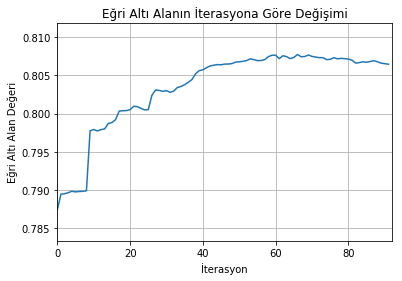

In [10]:
print('Eğri altı alan...')
ax = lgb.plot_metric(evals_result, metric='auc')
ax.set_title('Eğri Altı Alanın İterasyona Göre Değişimi')
ax.set_xlabel('İterasyon')
ax.set_ylabel('Eğri Altı Alan Değeri')
ax.legend_.remove()
plt.show()

Şekle göre ilk 20 iterasyonda başarının ciddi şekilde arttığı görülüyor. 40 numaralı iterasyondan sonra sonuçlardaki iyileşme daha az. 67 numaralı iterasyondan sonra ise sonuçlar kötüleşmeye başlamış (aşırı uyum).

`scikit-learn` üzerinde olduğu gibi `LightGBM` de özniteliklerin önemini görmemizi sağlayan bir fonksiyon içeriyor. `plot_importance` ile modelin, istediğiniz sayıda en önemli özniteliğini ağırlıklarıyla birlikte şekle dökebilirsiniz.

Aşağıda 10 öznitelik için (ve en iyi sonucu aldığımız iterasyondaki) önem grafiğini görebiliriz.

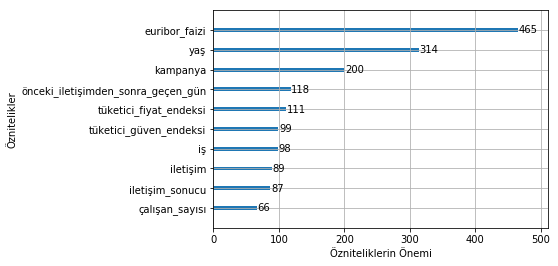

In [11]:
ax = lgb.plot_importance(gbm, max_num_features=10)
ax.set_title('')
ax.set_xlabel('Özniteliklerin Önemi')
ax.set_ylabel('Öznitelikler')
plt.show()

`euribor_faizi`,`yaş` ve `kampanya` önemi yüksek, yani kampanyaya cevabı belirleyen, özniteliklerden.

# Eksik veri ile çalışma

`LightGBM`, `scikit-learn` paketinin aksine eksik değerlerle çalışmaya da izin veriyor. Örnek olarak `önceki_iletişimden_sonra_geçen_gün` değeri 999 olan müşterilerin bu değerini `NaN` yapalım.

In [12]:
# Veri kümelerinde eksik değerler oluşturuyoruz.
df_train['önceki_iletişimden_sonra_geçen_gün'].replace(999, np.nan, inplace = True)
df_test['önceki_iletişimden_sonra_geçen_gün'].replace(999, np.nan, inplace = True)

print(df_train.isnull().sum())

yaş                                       0
iş                                        0
medeni_durum                              0
eğitim                                    0
gecikme                                   0
ev                                        0
borç                                      0
iletişim                                  0
ay                                        0
haftanın_günü                             0
kampanya                                  0
önceki_iletişimden_sonra_geçen_gün    27753
iletişim_sayısı                           0
iletişim_sonucu                           0
işsizlik                                  0
tüketici_fiyat_endeksi                    0
tüketici_güven_endeksi                    0
euribor_faizi                             0
çalışan_sayısı                            0
dtype: int64


Gördüğümüz gibi artık veri setinde eksik değerler de var. Modeli eğitip sonuçları alalım.

In [13]:
# Veri kümesi oluşturalım.
lgb_train = lgb.Dataset(data=df_train, label=y_train,  free_raw_data=False)
# Değerlendirme veri kümesini oluşturuyoruz.
lgb_eval = lgb.Dataset(data=df_test, label=y_test, reference=lgb_train,  free_raw_data=False)

# Eğitim parametrelerini belirleyelim
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

print('Eğitim...')
# Modeli eğitelim
evals_result={}
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                categorical_feature = kategorik_indeks,
                num_boost_round= 150,
                early_stopping_rounds= 25,
                evals_result=evals_result)
print('Eğitim bitti...')

# Tahmin ve değerlendirme
y_pred = gbm.predict(df_test, num_iteration=gbm.best_iteration)

print('En iyi sonucu veren iterasyon: ', gbm.best_iteration)
print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred))
print('İsabetlilik değeri:', accuracy_score(y_test, ( y_pred>= 0.5)*1))

Eğitim...
[1]	valid_0's auc: 0.78742
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's auc: 0.789475
[3]	valid_0's auc: 0.789526
[4]	valid_0's auc: 0.789663
[5]	valid_0's auc: 0.789849
[6]	valid_0's auc: 0.789768
[7]	valid_0's auc: 0.789819
[8]	valid_0's auc: 0.789839
[9]	valid_0's auc: 0.789914
[10]	valid_0's auc: 0.797747
[11]	valid_0's auc: 0.797924
[12]	valid_0's auc: 0.797677
[13]	valid_0's auc: 0.798105
[14]	valid_0's auc: 0.798295
[15]	valid_0's auc: 0.798434
[16]	valid_0's auc: 0.799106
[17]	valid_0's auc: 0.79919
[18]	valid_0's auc: 0.799513
[19]	valid_0's auc: 0.800609
[20]	valid_0's auc: 0.800532
[21]	valid_0's auc: 0.800621
[22]	valid_0's auc: 0.801409
[23]	valid_0's auc: 0.801717
[24]	valid_0's auc: 0.801748
[25]	valid_0's auc: 0.801865
[26]	valid_0's auc: 0.803003
[27]	valid_0's auc: 0.803296
[28]	valid_0's auc: 0.803565
[29]	valid_0's auc: 0.803508
[30]	valid_0's auc: 0.803256
[31]	valid_0's auc: 0.803135
[32]	valid_0's auc: 0.803365
[33]	valid_

Gördüğümüz gibi eksik değerlerle yapılan tahminler biraz daha iyi sonuçlar verdi. Ancak her zaman bu şekilde olacağının bir garantisi yok. Hangi modeli kullanacağımızı belirlemek için birden fazla alternatifi çarpraz doğrulama ve istatistik yöntemleriyle test etmemiz gerekecektir. 

`LightGBM` veri analitiği konusunda kullanabileceğiniz bir çok aracı içeren bir paket. Ancak `scikit-learn` gibi uçtan uca bir çözüm sunmuyor. Veri işleme ve model sonuçlarını değerlendirme gibi alanlarda `scikit-learn` altındaki modülleri kullanmak durumunda kaldık. Bu noktada, `LightGBM` paketinin bir yapay öğrenme kütüphanesi olmadığını ve gradient boosting yöntemine dayanan bir kütüphane olduğunu hatırlatalım.

Bu yazının Jupyter Notebook dosyasına [Github](https://github.com/sibirbil/VeriDefteri) dizinimizden erişebilirsiniz.